In [2]:
#Imports
import wandb
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from PIL import Image
from diffusers import DDPMScheduler, DDIMScheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
import os
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
from dataclasses import dataclass
import torch.distributions as D
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

/home/shervink/miniconda3/envs/alignprop/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Annealed Samplers
class AnnealedMALASampler:
  """Implements AIS with ULA"""

  def __init__(self,
               num_steps,
               num_samples_per_step,
               step_sizes,
               gradient_function,
               ):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_samples_per_step = num_samples_per_step
    self._gradient_function = gradient_function


  def sample_step(self, x, t,ts, model_args):
  
    e_old,grad = self._gradient_function(x, ts, **model_args)
    for i in range(self._num_samples_per_step):
      ss = self._step_sizes[t]
      std = (2 * ss) ** .5
      noise = torch.randn_like(grad) * std

      x_proposal  = x + grad * ss + noise

      # Compute Energy of the samples 
      e_new,grad_new = self._gradient_function(x_proposal, ts, **model_args)

      log_xhat_given_x = -1.0*((x_proposal - x - ss * grad) ** 2).sum() / (2 * ss**2)
      log_x_given_xhat = -1.0 * ((x - x_proposal - ss * grad_new) ** 2).sum() / (2 * ss**2)
      log_alpha = e_new-e_old +log_x_given_xhat - log_xhat_given_x 
      
      # Acceptance Ratio
      if torch.log(torch.rand(1)) < log_alpha.detach().cpu():
        x = x_proposal
        e_old = e_new
        grad = grad_new

    return x

def leapfrog_step_c(x_0,
                  v_0,
                  gradient_target,
                  step_size,
                  mass_diag_sqrt,
                  num_steps,
                  grad_i):
  """Multiple leapfrog steps with no metropolis correction."""
  x_k = x_0
  v_k = v_0
  grad_k = grad_i 
  if mass_diag_sqrt is None:
    mass_diag_sqrt = torch.ones_like(x_k)

  mass_diag = mass_diag_sqrt ** 2.

  for _ in range(num_steps):  
    v_k += 0.5 * step_size *grad_k#  # half step in v
    x_k += step_size * v_k / mass_diag  # Step in x
    grad_k = gradient_target(x_k)[1]
    v_k += 0.5 * step_size * grad_k  # half step in v
  

  return x_k, v_k



class AnnealedCHASampler:

  def __init__(self,
               num_steps,
               num_samples_per_step,
               step_sizes,
               damping_coeff,
               mass_diag_sqrt,
               num_leapfrog_steps,
               gradient_function,
               ):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._damping_coeff = damping_coeff
    self._mass_diag_sqrt = mass_diag_sqrt
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_leapfrog_steps = num_leapfrog_steps
    self._num_samples_per_step = num_samples_per_step
    self._gradient_function = gradient_function


  def leapfrog_step_(self, x, v, i, ts, grad_i,model_args):
    
    step_size = self._step_sizes[i]
    return leapfrog_step_c(x, v, lambda _x: self._gradient_function(_x, ts, **model_args), step_size, self._mass_diag_sqrt[i], self._num_leapfrog_steps,grad_i)


  def sample_step(self, x, t,ts, model_args):



    M=self._mass_diag_sqrt[t] # VAR 
    
    # Sample Momentum
    v = torch.randn_like(x) * M 
    # v_dist = torch.distributions.normal.Normal(torch.zeros_like(x).cuda(), torch.ones_like(x).cuda() * M)
    # v = v_dist.sample().cuda()

    for i in range(self._num_samples_per_step):
      # Partial Momentum Refreshment
      eps = torch.randn_like(x)
      v_prime = v * self._damping_coeff + np.sqrt(1. - self._damping_coeff**2) * eps * M
      
      energy_i, grad_i = self._gradient_function(x,ts,**model_args)
      x_old = x.clone()
      v_old =  v.clone()
      x_new, v_new = self.leapfrog_step_(x, v_prime, t, ts,grad_i, model_args)
      
      energy_new, grad_new = self._gradient_function(x_new,ts,**model_args)
      energy_diff = energy_new-energy_i


      # log_v = torch.sum(v_dist.log_prob(v_prime))
      # log_v_new = torch.sum(v_dist.log_prob(v_new))

      
      log_v_new = (-0.5*(1/M**2)) *torch.sum(v_new**2) # As mean 0 and Variance M**2 
      log_v = (-0.5*(1/M**2)) *torch.sum(v_prime**2) 


      logp_accept = energy_diff + (log_v_new - log_v)
      alpha = torch.min(torch.tensor(1.0),torch.exp(logp_accept))

      u = torch.rand(1)
      if u <=alpha.cpu():  
        x = x_new
        v = v_new
      else:
        x = x_old
        v = v_old
    
      # alpha = torch.exp(logp_accept)
      # mask = (torch.rand(x.shape[0]).cuda() < alpha).float().unsqueeze(1).unsqueeze(2).unsqueeze(3)
      # x = mask * x_new + (1 - mask) * x
      # v = mask * v_new + (1 -mask) * v_prime

    return x

def leapfrog_step(x_0,
                  v_0,
                  gradient_target,
                  step_size,
                  mass_diag_sqrt,
                  num_steps,
                  ):
  # """Multiple leapfrog steps with no metropolis correction."""
  x_k = x_0
  v_k = v_0
  if mass_diag_sqrt is None:
    mass_diag_sqrt = torch.ones_like(x_k)

  mass_diag = mass_diag_sqrt ** 2.
  grad = gradient_target(x_k)
  for _ in range(num_steps):  # Inefficient version - should combine half steps
    v_k += 0.5 * step_size * grad#gradient_target(x_k)  # half step in v
    x_k += step_size * v_k / mass_diag  # Step in x
    grad = gradient_target(x_k)
    v_k += 0.5 * step_size * grad  # half step in v
  return x_k, v_k




class AnnealedUHASampler:
  """Implements UHA Sampling"""

  def __init__(self,
               num_steps,
               num_samples_per_step,
               step_sizes,
               damping_coeff,
               mass_diag_sqrt,
               num_leapfrog_steps,
               gradient_function,
               ):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._damping_coeff = damping_coeff
    self._mass_diag_sqrt = mass_diag_sqrt
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_leapfrog_steps = num_leapfrog_steps
    self._num_samples_per_step = num_samples_per_step
    self._gradient_function = gradient_function


  def leapfrog_step_(self, x, v, i, ts, model_args):
      step_size = self._step_sizes[i]
      return leapfrog_step(x, v, lambda _x: self._gradient_function(_x, ts, **model_args), step_size, self._mass_diag_sqrt[i], self._num_leapfrog_steps)


  def sample_step(self, x, t,ts, model_args):

    # Sample Momentum
    v = torch.randn_like(x) * self._mass_diag_sqrt[t]

    for i in range(self._num_samples_per_step):

      # Partial Momentum Refreshment
      eps = torch.randn_like(x)

      v = v * self._damping_coeff + np.sqrt(1. - self._damping_coeff**2) * eps * self._mass_diag_sqrt[t]

      x, v = self.leapfrog_step_(x, v, t, ts, model_args)

    return x

class AnnealedULASampler:
  """Implements AIS with ULA"""

  def __init__(self,
               num_steps,
               num_samples_per_step,
               step_sizes,
               gradient_function
               ):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_samples_per_step = num_samples_per_step
    self._gradient_function = gradient_function


  def sample_step(self, x, t, scalar, model):

    for i in range(self._num_samples_per_step):
      ss = self._step_sizes[t]
      std = (2 * ss) ** .5
      grad = self._gradient_function(x, t, model, scalar)
      noise = torch.randn_like(grad) * std
      x = x + grad * ss + noise
    return x

In [4]:
def gradient(x_t, ts, model, scalar):
    eps = model(x_t, ts)
    # Need to scale the gradients by coefficient to properly account for normalization in DSM loss + data contraction
    scale = scalar[ts.item()]
    return -1*scale*eps

In [7]:
#Function for sampling 2D data points from the diffusion model
def sample_images_ddpm(unet, scheduler, batch_size = 2, num_inference_steps = 1000, sampler = None):


    device = 'cuda:0'

    alphas = 1 - scheduler.betas
    alphas_cumprod = np.cumprod(np.array(alphas))
    scalar = np.sqrt(1 / (1 - alphas_cumprod))
    # Sample gaussian noise to begin loop
    
    # unet.to(device)

    image_shape = (batch_size, 2)

    image = torch.randn(image_shape, requires_grad=False).to(device)*0.1

    # set step values
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps, desc="Sampling"):

        if sampler is None:
            # 1. predict noise model_output
            model_output = unet(image, t*torch.ones(batch_size, dtype=torch.long, device = device))
            # 2. compute previous image: x_t -> x_t-1
            image = scheduler.step(model_output, t, image).prev_sample
        else:
   
            image = sampler.sample_step(image, t.to(device), scalar, unet)
   

    return image


In [8]:
#DISTRIBUTIONS
#Configuration of Training hyperparameters
@dataclass

class TrainingConfig:

    adaptation = False #If adaptation = True, the problem will be treated as a adaptation/fine-tuning problem where we want to adapt a pre-trained model to new data without overfitting.

    image_size = 32 # the generated image resolution (the training data will be resized to image_size*image_size)
    latent_size = 32 # Latent resolution (ignore if not using latent diffusion)
    diffusion_channels = 1 #1 for b&w images, 3 for RGB, 4 or more for latent diffusion

    primal_batch_size = 128 #number of images in each mini-batch sampled for computing the primal loss
    dual_batch_size = 64 #number of images in each mini-batch sampled for computing each constraint loss
    eval_batch_size = 64 # how many samples to sample during evaluation step

    num_epochs = 100 #number of total epochs
    batches_per_epoch = 4 #number of mini-batches per epoch
    primal_per_dual = 5 #number of primal descent steps after each update of the dual variables
    
    save_model_epochs = 30 # number of epochs between each time the model is saved
    save_plot_epochs = 20 # number of epochs between each time plots of relevant variables are saved
    save_image_epochs = 10 # number of epochs between each time a batch of images generated by the diffusion model are saved
    running_average_length = 5 #length of the running average for plotting average histograms of generated samples during training

    num_gpus = 2 #number of gpus to split the training on using the 'accelerate' library

    load_model_header = 'MODEL_NAME' # header of the initial model to load from the 'save_models_dir' directory. used if continuing training of a previusly trained model or fine-tuning a pre-trained model.
    save_model_header = 'saved' # header to save the model with 

    gradient_accumulation_steps = 1

    lr_primal = 1e-5 # the maximum primal learning rate
    lr_dual = 1.0 #ratio of dual learning rate to primal learning rate
    lr_warmup_steps = 10 # number of warmup steps to use in the learning rate scheduler

    evaluate = True #set to True if you want the model to sample images from the diffusion model after every #save_image_epochs steps.
    wandb_logging = False #set to True if you want to log relevant variables to wandb

    architecture_size = 128 # the size of the denoising U-net model can be scaled up or down using this parameter

    
    dataset_name = 'mnist' #name of the dataset to use for training. could be one of ['mnist', 'celeb-a', 'image-net']

    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision

    upload_to_github = True #If True, in addition to saving plots and imgs to file, will upload them to github repo
    github_token = " "
    github_repo = " "

    output_dir = "FOLDER_NAME"  # the local directory name to save everything
    save_models_dir = "models" # the local directory to save trained models
    
    T = 100 #number of diffusion steps

config = TrainingConfig()


In [9]:
#Gaussian Mixture Dataset Class

class GaussianMixture:
    def __init__(self, means, covariances,  weights=None, sample_size = 1000):
        """
        Initialize the dataset with a mixture of Gaussians.

        Parameters:
        - num_components (int): Number of Gaussian components in the mixture.
        - num_dimensions (int): Dimensionality of each sample.
        - num_samples (int): Total number of samples to generate.
        - means (torch.Tensor, optional): Means of the Gaussian components. Defaults to random values.
        - covariances (torch.Tensor, optional): Covariance matrices of the Gaussian components. Defaults to identity matrices.
        - weights (torch.Tensor, optional): Weights of the Gaussian components. Defaults to equal weights.
        """
        
        self.num_components = means.shape[0]
        self.num_dimensions = means.shape[1]

        self.means = means
        
        self.covariances = covariances
        self.inverse_covariances = [torch.linalg.inv(self.covariances[i]) for i in range(self.num_components)]
        if weights is None:
            self.weights = torch.ones(self.num_components) / self.num_components  # Equal weights
        else:
            self.weights = weights
        self.weights = self.weights.to(self.means.device)
        
        # Create the mixture distribution
        self.mixture_distribution = D.Categorical(self.weights)
        self.component_distribution = D.MultivariateNormal(self.means, self.covariances)
        self.individual_distributions = [D.MultivariateNormal(self.means[i], self.covariances[i]) for i in range(self.num_components)]
        self.gmm = D.MixtureSameFamily(self.mixture_distribution, self.component_distribution)
        
    def predict_noise(self, image, alpha_bar_t):
        noise_pred = 0
        for i in range(self.num_components):
            # Compute posterios mixture weight (aka responsability)
            gamma = torch.exp(torch.log(self.weights[i])+self.individual_distributions[i].log_prob(image)-self.gmm.log_prob(image))
            noise_pred += gamma.unsqueeze(1)*(image-self.means[i].unsqueeze(0))@self.inverse_covariances[i].unsqueeze(0)
        return torch.sqrt(1 - alpha_bar_t)*noise_pred

class GMMDataset(Dataset):
    def __init__(self, means, covariances, num_samples = 1000, weights=None):
        """
        Initialize the dataset with a mixture of Gaussians.

        Parameters:
        - num_components (int): Number of Gaussian components in the mixture.
        - num_dimensions (int): Dimensionality of each sample.
        - num_samples (int): Total number of samples to generate.
        - means (torch.Tensor, optional): Means of the Gaussian components. Defaults to random values.
        - covariances (torch.Tensor, optional): Covariance matrices of the Gaussian components. Defaults to identity matrices.
        - weights (torch.Tensor, optional): Weights of the Gaussian components. Defaults to equal weights.
        """
        
        self.num_components = means.shape[0]
        self.num_dimensions = means.shape[1]
        
        self.num_samples = num_samples

        self.means = means
        
        self.covariances = covariances
        
        if weights is None:
            self.weights = torch.ones(self.num_components) / self.num_components  # Equal weights
        else:
            self.weights = weights
        
        # Create the mixture distribution
        self.mixture_distribution = D.Categorical(self.weights)
        self.component_distribution = D.MultivariateNormal(self.means, self.covariances)
        self.gmm = D.MixtureSameFamily(self.mixture_distribution, self.component_distribution)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate a sample from the mixture distribution
        sample = self.gmm.sample()
        return sample



In [10]:
#Resnet Block for 2D data
class ResNetBlock2D(nn.Module):
    """
    A single ResNet block for 2D data with multiple fully connected layers.
    """
    def __init__(self, hidden_dim=20):
        super(ResNetBlock2D, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Define layers with bias terms
        self.fc1 = nn.Linear(2, self.hidden_dim, bias=True)
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.fc3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.fc4 = nn.Linear(self.hidden_dim, 2, bias=True)
        
        # Initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)

    def forward(self, x):
        identity = x  # Save input for residual connection

        # Pass through layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        # Add residual connection
        x = x + identity

        return x


In [11]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal timestep embeddings used as alternative to learned embeddings."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResnetDiffusionModel(nn.Module):
    """PyTorch implementation of JAX Resnet score model.
    
    Adds embedding for each scale after each linear layer.
    """
    def __init__(
        self,
        n_steps,
        n_layers,
        x_dim,
        h_dim,
        emb_dim,
        widen=2,
        emb_type='learned'
    ):
        super().__init__()
        assert emb_type in ('learned', 'sinusoidal')
        
        self.n_layers = n_layers
        self.n_steps = n_steps
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.widen = widen
        self.emb_type = emb_type
        
        # Time embedding
        if self.emb_type == 'learned':
            self.time_embed = nn.Embedding(n_steps, emb_dim)
        else:
            self.time_embed = SinusoidalPositionEmbeddings(emb_dim)
            
        # Initial linear layer
        self.input_linear = nn.Linear(x_dim, h_dim)
        
        # Resnet blocks
        self.res_blocks = nn.ModuleList()
        for _ in range(n_layers):
            block = nn.ModuleDict({
                'norm': nn.LayerNorm(h_dim),
                'layer_h': nn.Linear(h_dim, h_dim * widen),
                'layer_emb': nn.Linear(emb_dim, h_dim * widen),
                'layer_int': nn.Linear(h_dim * widen, h_dim * widen),
                'layer_out': nn.Linear(h_dim * widen, h_dim)
            })
            # Initialize output layer weights to zero
            nn.init.zeros_(block['layer_out'].weight)
            nn.init.zeros_(block['layer_out'].bias)
            
            self.res_blocks.append(block)
            
        # Final output layer
        self.final_linear = nn.Linear(h_dim, x_dim)
        nn.init.zeros_(self.final_linear.weight)
        nn.init.zeros_(self.final_linear.bias)
        
    def forward(self, x, t=None):
        # Handle case when only x is provided (for compatibility with existing code)
        if t is None:
            # For the basic case, we'll just use timestep 0
            t = torch.zeros(x.shape[0], dtype=torch.long, device=x.device)
            
        # Make sure x is 2D
        if x.dim() == 3 and x.size(0) == 1:  # Handle [1, batch_size, x_dim]
            x = x.squeeze(0)
            
        # Embed timestep
        emb = self.time_embed(t)
        
        # Initial projection
        h = self.input_linear(x)
        
        # Process through residual blocks
        for block in self.res_blocks:
            # Residual connection
            residual = h
            
            # Layer norm and first activation
            h = block['norm'](h)
            h = F.silu(h)  # silu is the same as swish
            
            # First dense layer
            h = block['layer_h'](h)
            
            # Add time embedding
            h = h + block['layer_emb'](emb)
            
            # Second activation and dense layer
            h = F.silu(h)
            h = block['layer_int'](h)
            
            # Third activation and output dense layer
            h = F.silu(h)
            h = block['layer_out'](h)
            
            # Add residual connection
            h = h + residual
            
        # Final layer
        output = self.final_linear(h)
        
        return output

In [12]:
#UNCONSTRAINED TRAIN LOOP
#Train Loop Function
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, mean, cov):
    
    loss_hist = np.zeros(config.num_epochs)

    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb" if config.wandb_logging else None,
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if config.wandb_logging:
        accelerator.init_trackers(
                project_name="simple_constrained_diffusion_tests",
                config=config,
            )
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, lr_scheduler = accelerator.prepare(
        model, optimizer, lr_scheduler
    )
    
    dataloader = accelerator.prepare(train_dataloader)
    iterator = iter(dataloader)

    global_step = 0

    # Now you train the model
    
    progress_bar = tqdm(total=config.num_epochs, disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Training Progress")
    
    
        
    for epoch in range(config.num_epochs):    

        for step in range(config.batches_per_epoch):

            device = accelerator.device
            try:
                train_features = next(iterator)
            except StopIteration:
                iterator = iter(dataloader)  # Reset the iterator
                train_features = next(iterator)
            
            if not isinstance(train_features, torch.Tensor):
                train_features = train_features[0]

            Clean_images = train_features.to(device)
            Noises = torch.randn(Clean_images.shape, device = Clean_images.device)
            Batch_sizes = Clean_images.shape[0]
            Timesteps = torch.randint(
                        0, config.T, (Batch_sizes,), device = Clean_images.device,
                        dtype = torch.int64
                    )
            Noisy_images = noise_scheduler.add_noise(Clean_images, Noises, Timesteps)


            with accelerator.accumulate(model):

                Noise_preds = model(Noisy_images.unsqueeze(0), Timesteps)


                Losses = F.mse_loss(Noise_preds.squeeze(), Noises)

                accelerator.backward(Losses)
                
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
        if config.wandb_logging:
            accelerator.log({"loss": Losses}, step = epoch)
            accelerator.log({"lr": lr_scheduler.get_last_lr()[0]}, step = epoch)
                
        progress_bar.update(1)
            
        if (epoch%config.save_plot_epochs == 0 or epoch == config.num_epochs - 1) and accelerator.is_main_process:
            
        
            fig = visualize_generated_samples(model, noise_scheduler, config, mean, cov)
            
            fig.show()
            fig.close()
           
            # Log the plot
            # For Weights & Biases
            # if config.wandb_logging:
            #     fig = wandb.Image(fig)
            #     accelerator.log({"Generated Samples Histogram": fig}, step = epoch)

            
            
    if accelerator.is_main_process and hasattr(accelerator, "trackers") and accelerator.trackers:
        accelerator.end_training()


In [13]:
def project_onto_simplex(x: torch.Tensor) -> torch.Tensor:
    """
    Projects a 1D tensor x onto the simplex:
       { u : u[i] >= 0, sum_i u[i] = 1 }.
    """
    # Sort x in descending order
    sorted_x, sorted_indices = torch.sort(x, descending=True)

    # Accumulate the sorted values
    cssv = torch.cumsum(sorted_x, dim=0)

    # Identify the smallest k such that sorted_x[k] - (cssv[k] - 1) / (k+1) > 0
    # (Note: we shift by one because of 0-based indexing)
    rhos = sorted_x - (1.0 / torch.arange(1, x.numel() + 1, device=x.device)) * (cssv - 1)
    rho = torch.nonzero(rhos > 0, as_tuple=True)[0][-1]

    # The threshold to subtract
    theta = (cssv[rho] - 1.0) / (rho + 1.0)

    # Re-project and clamp to zero
    return torch.clamp(x - theta, min=0)

In [14]:
#CONSTRAINED TRAIN LOOP
def constrained_train_loop(config, model, noise_scheduler, optimizer, train_distributions, lr_scheduler, init_mus = None, b = None):

    
    # Create a figure with 10 subplots (2 rows, 5 columns)
    # fig, axes = plt.subplots(int(config.num_epochs/config.save_plot_epochs//5), 5, figsize=(15, 3*int(config.num_epochs/config.save_plot_epochs//5)))
    # axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Initialize the figure
    
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb" if config.wandb_logging else None,
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if config.wandb_logging:
        accelerator.init_trackers(
                project_name="simple_constrained_diffusion_tests",
                config=config,
            )
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, lr_scheduler = accelerator.prepare(
        model, optimizer, lr_scheduler
    )
    

    #Nc is the number of constraints here
    Nc = len(train_distributions)
    
    nc = np.zeros(Nc)

    if init_mus is not None:
        mu = init_mus
    else:
        mu = 1/Nc*torch.ones(Nc, requires_grad = False).to(accelerator.device)
    
    if b is not None:
        b = b
    else:
        b = torch.zeros(Nc, requires_grad = False).to(accelerator.device)
    

    # Now you train the model
    
    progress_bar = tqdm(total=config.num_epochs, disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Training Progress")
    
    
    image_shape = (config.primal_batch_size, 2) 
    for epoch in range(config.num_epochs):
        for step in range(config.batches_per_epoch):
             
            image = torch.randn(image_shape).to(accelerator.device)
            KLs = [0]*Nc

            # 2. Evaluate lagrangian
            lag = torch.zeros(1, requires_grad = False).to(accelerator.device)
  
            for t in noise_scheduler.timesteps:
                # Get diffusion parameters for KL calculation
                alpha_bar_t = noise_scheduler.alphas_cumprod[t]
                beta_t = noise_scheduler.betas[t] 
                coeff = beta_t**2 / (2 * (1-beta_t) * (alpha_bar_t))

                model_output = model(image, t*torch.ones(config.primal_batch_size, dtype=torch.long, device = accelerator.device))
                gt_noise_preds = []

                for l in range(Nc):
                    if isinstance(train_distributions[l], nn.Module):
                        noise_pred = train_distributions[l](image).squeeze()
                    else:
                        noise_pred = train_distributions[l].predict_noise(image, noise_scheduler.alphas_cumprod[t])

                    gt_noise_preds += [noise_pred]

                
                    
                    Losses = []

                for l in range(Nc):
                    mse_t = F.mse_loss(model_output, gt_noise_preds[l].squeeze())
                    Losses += [mse_t]
                    KLs[l] += coeff*mse_t.item()
                    lag += mu[l]*Losses[l]

                    # 3. compute previous image: x_t -> x_t-1
                image = noise_scheduler.step(model_output.detach(), t, image).prev_sample

            with accelerator.accumulate(model):

                accelerator.backward(lag)
                

                ############### DUAL STEP START #############
                current_lr = lr_scheduler.get_last_lr()[0]
                
                m = mu.shape[0]

                if (epoch + 1)%config.primal_per_dual == 0:
                    
                    lr_dual = config.lr_dual
                    l = torch.tensor(KLs, requires_grad = False).to(mu.device)
                    b = b.to(mu.device)
                    grad = lr_dual*(l - b)
                    
                    if torch.linalg.norm(grad).detach() != 0:   
                        # GD step
                        mu = (mu + grad).detach()
                        # make sure mu is in the simplex
                        mu = project_onto_simplex(mu)

            
                ################ DUAL STEP END ###############
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            if config.wandb_logging:
                accelerator.log({"lagrangian": lag}, step = epoch)
                
                for k in range(mu.shape[0]):
                    accelerator.log({"mu " + str(k + 1): mu[k]}, step = epoch)
                    accelerator.log({"loss " + str(k + 1): Losses[k]}, step = epoch)
                    accelerator.log({"Dkl " + str(k + 1): KLs[k]}, step = epoch)

                lr = lr_scheduler.get_last_lr()[0]
                accelerator.log({"lr": lr}, step = epoch)
                    
            progress_bar.update(1)
                
            if epoch%config.save_plot_epochs == 0 and accelerator.is_main_process:



                fig = visualize_generated_samples(model, noise_scheduler, config)
                
                
                
            
                # # Create loss curve plot
                # fig, ax = plt.figure(figsize=(10, 10)), plt.gca()
                
                # images =( sample_images_ddpm(model, noise_scheduler, batch_size = 5000, num_inference_steps = config.T)).detach().cpu().numpy()
                
                # ax.hist2d(images[:, 0], images[:, 1], bins=50, cmap=plt.cm.binary)
                # ax.set_xlim(-2.5, 2.5)
                # ax.set_ylim(-2.5, 2.5)
        
           
                # Log the plot
                # For Weights & Biases
                if config.wandb_logging:
                    fig = wandb.Image(fig)
                    accelerator.log({"Generated Samples Histogram": fig}, step = epoch)

            
        
            # nc[0] = np.sum(images[:, 1] < 0)
            # nc[1] = np.sum(images[:, 1] > 0)
            
            for k in range(Nc):
                if config.wandb_logging:
                    accelerator.log({"mu " + str(k + 1): mu[k]}, step = epoch)

                    accelerator.log({"Dkl " + str(k + 1): KLs[k]}, step = epoch)

            accelerator.log({"lagrangian": lag}, step = epoch)

            
            
    if accelerator.is_main_process and hasattr(accelerator, "trackers") and accelerator.trackers:
        accelerator.end_training()

    return {"mu": mu, "b": b, "KLs": KLs, "Losses": Losses} 


In [15]:
#VISUALIZATION FUNCTIONS

from scipy.stats import multivariate_normal

def sample_images(unet, noise_scheduler, batch_size = 1, num_inference_steps = 1000):

    image = torch.randn((batch_size, 2)).cuda()

    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            model_output = unet(
                image, 
                t*torch.ones(batch_size, dtype=torch.long, device=image.device)
            )
        image = noise_scheduler.step(model_output, t, image).prev_sample
            
    samples = image

    return samples


def sample_composition(score_models, weights, noise_scheduler, batch_size = 1, num_inference_steps = 1000):
    print('sampling with weights', weights)
    image = torch.randn((batch_size, 2)).cuda()

    for t in noise_scheduler.timesteps:
        final_model_output = torch.zeros_like(image).to(image.device)
        with torch.no_grad():
            for i in range(len(score_models)):
                model_output = score_models[i](
                    image, 
                    t*torch.ones(batch_size, dtype=torch.long, device=image.device)
                )
                final_model_output += model_output*weights[i]

        image = noise_scheduler.step(final_model_output, t, image).prev_sample
            
    samples = image

    return samples
    
    


noise_scheduler = DDIMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02, clip_sample=False)
noise_scheduler.set_timesteps(config.T)

def visualize_generated_samples(score_model, scheduler, config, means = None, variances = None, batch_size = 5000, mus = None, samples = None):

    if samples is None:
        images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()
    else:
        images = samples.detach().cpu().numpy()

    plt.figure(figsize=(5, 5))

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    if means is not None:
        # Plot contours of the Gaussian distribution
        
        

        for i in range(len(means)):
            mean = means[i].numpy()
            cov = variances[i] * np.eye(2)
            rv = multivariate_normal(mean, cov)
            
            Z = rv.pdf(pos)
            plt.contour(X, Y, Z, levels=5, alpha=0.5, colors='blue')

            if mus is not None:
                plt.text(mean[0], mean[1], f'μ = {mus[i].detach().cpu().numpy()}', fontsize=8)

    # images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()
    plt.scatter(images[:, 0], images[:, 1], alpha = 0.2)

    # Calculate and plot mean of generated samples
    sample_mean = np.mean(images, axis=0)
    plt.hist2d(images[:, 0], images[:, 1], bins=100, cmap='Oranges', density=True)
    plt.colorbar(label='Density')
    plt.legend()
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Generated Samples with Sample Mean')

    


    # Plot sample mean and covariance contours
    sample_cov = np.cov(images.T)

    # Plot mean point
    plt.plot(sample_mean[0], sample_mean[1], 'r*', markersize=15, label='Sample Mean')


    # Plot contours of the sample distribution
    sample_rv = multivariate_normal(sample_mean, sample_cov)
    Z_sample = sample_rv.pdf(pos)
    plt.contour(X, Y, Z_sample, levels=5, alpha=0.5, colors='red', linestyles='dashed', label='Sample Distribution')

    plt.xlim(-1.25, 1.25)
    plt.ylim(-1.25, 1.25)

    return plt


In [16]:
#LOAD MODELS
import glob
score_models = {}
model_files = glob.glob('saved_models/score_model_*.pt')
for model_path in model_files:
    model_name = os.path.basename(model_path).replace('.pt','')
    model = ResnetDiffusionModel(
        n_steps=config.T,
        n_layers=4,
        x_dim=2,
        h_dim=128,
        emb_dim=32,
        widen=2,
        emb_type='learned'
    ).cuda()  # Move model to GPU

    model.load_state_dict(torch.load(model_path))
    model = model.cuda()  # Ensure model is on GPU after loading state dict
    score_models[model_name] = model

print(f"Loaded {len(score_models)} saved models to GPU")
print("Available models:", list(score_models.keys()))


/tmp/ipykernel_528010/3665977822.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loaded 5 saved models to GPU
Available models: ['score_model_2', 'score_model_0', 'score_model_constrained', 'score_model_unconstrained', 'score_model_1']


/tmp/ipykernel_528010/3828648456.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col[i], markersize=15, label='Sample Mean')
/tmp/ipykernel_528010/3828648456.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.075, colors=[col[i]], label='Sample Distribution')
/tmp/ipykernel_528010/3828648456.py:84: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_sample, levels=levels, alpha=0.15, colors=col[i], label='Sample Distribution')


[-0.19054449 -0.00819066]
[1.91856122e-05 1.02613919e-01 2.05208652e-01 3.07803386e-01
 4.10398119e-01 5.12992853e-01 6.15587586e-01 7.18182319e-01
 8.20777053e-01 9.23371786e-01]


/tmp/ipykernel_528010/3828648456.py:212: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_sample, levels=levels[5:], alpha=0.1, colors=col_unconstrained, linestyles='dashed', label='Sample Distribution')
/tmp/ipykernel_528010/3828648456.py:213: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_sample, levels=levels[5:6], alpha=0.5, colors=col_unconstrained, label='Sample Distribution')


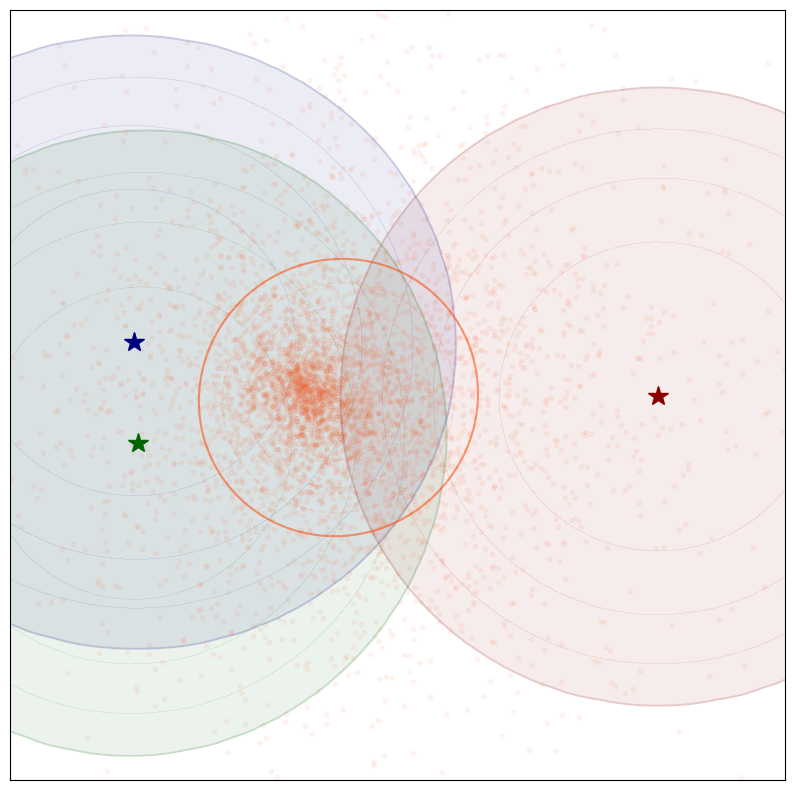

In [58]:
# visualize_generated_samples(score_models['score_model_constrained'], noise_scheduler, config)

plt.figure(figsize=(10, 10))

xlim = 1.25
ylim = 1.25

cmaps = ['Oranges', 'Blues', 'Greens']
col = ['darkred', 'navy', 'darkgreen']

grid = False

cmap_constrained = 'Greys'
col_constrained = 'teal'

cmap_unconstrained = 'Greys'
col_unconstrained = 'orangered'

for i, key in enumerate(['score_model_0', 'score_model_1', 'score_model_2']):

    score_model = score_models[key]
    batch_size = 5000

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()

    # Calculate and plot mean of generated samples
    sample_mean = np.mean(images, axis=0)

    plt.grid(grid)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])

    # Plot sample mean and covariance contours
    sample_cov = np.cov(images.T)

    # Plot mean point
    plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col[i], markersize=15, label='Sample Mean')

    # Plot contours of the sample distribution
    sample_rv = multivariate_normal(sample_mean, sample_cov)
    Z_sample = sample_rv.pdf(pos)
    
    # Create more contour levels with logarithmic spacing
    levels = np.logspace(np.log10(Z_sample.max()/1000), np.log10(Z_sample.max()), 5)
    
    # Fill the contour with color
    plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.075, colors=[col[i]], label='Sample Distribution')

    

    levels = np.logspace(np.log10(Z_sample.max()/1000), np.log10(Z_sample.max()), 1)


    # # Store Z values for intersection calculation
    # level_ind = -1
    # print(levels[level_ind])
    # if i == 0:
    #     Z1 = Z_sample > levels[level_ind]  # Binary mask above lowest contour level
    # elif i == 1:
    #     Z2 = Z_sample > levels[level_ind]
    # else:
    #     Z3 = Z_sample > levels[level_ind]
    #     # Highlight intersection of all three contours
    #     intersection = Z1 & Z2 & Z3
    #     print('Z1', Z1)
    #     print('Z2', Z2)
    #     print('Z3', Z3)
    #     print('intersection', intersection)
    #     # Print coordinates where intersection is True
    #     intersection_coords = np.where(intersection)
    #     print("Intersection coordinates (y,x):", list(zip(intersection_coords[0], intersection_coords[1])))
    #     print("Corresponding X,Y values:")

    #     plt.contourf(X, Y, intersection, colors=['yellow'], alpha=0.3)

    
    plt.contour(X, Y, Z_sample, levels=levels, alpha=0.15, colors=col[i], label='Sample Distribution')

    plt.xlim(-xlim, xlim)
    plt.ylim(-ylim, ylim)


#constrained
if False:
    score_model = score_models['score_model_constrained']
    batch_size = 5000

        

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))



    images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()

    plt.scatter(images[:, 0], images[:, 1], marker='.', color=col_constrained, alpha = 0.05)

    hist_lim = 0.5

    # Calculate and plot mean of generated samples
    sample_mean = np.mean(images, axis=0)
    print(sample_mean)
    # plt.hist2d(images[:, 0], images[:, 1], bins=100, cmap=cmap_constrained, density=True, alpha=1.0, range=[[-hist_lim, hist_lim], [-hist_lim, hist_lim]])
    # plt.colorbar(label='Density')

    plt.grid(grid)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])




    # Plot sample mean and covariance contours
    sample_cov = np.cov(images.T)

    # Plot mean point
    # plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col_constrained, markersize=15, label='Sample Mean')


    # Plot contours of the sample distribution

    x = np.linspace(-xlim, xlim, 100)
    y = np.linspace(-ylim, ylim, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))


    sample_rv = multivariate_normal(sample_mean, sample_cov)
    Z_sample = sample_rv.pdf(pos)
    levels = np.linspace(Z_sample.min(), Z_sample.max(), 10)  # Create 10 evenly spaced contour levels
    print(levels)
    # Create logarithmically spaced levels between min and max of Z_sample
    log_levels = np.logspace(np.log10(Z_sample.min()), np.log10(Z_sample.max()), 20)

    plt.contour(X, Y, Z_sample, levels=levels[5:], alpha=0.1, colors=col_constrained, linestyles='dashed', label='Sample Distribution')
    plt.contour(X, Y, Z_sample, levels=levels[5:6], alpha=0.5, colors=col_constrained, label='Sample Distribution')






#unconstrained
if True:
    score_model = score_models['score_model_unconstrained']
    batch_size = 5000

        

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))



    images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()

    plt.scatter(images[:, 0], images[:, 1], marker='.', color=col_unconstrained, alpha = 0.05)

    hist_lim = 0.5

    # Calculate and plot mean of generated samples
    sample_mean = np.mean(images, axis=0)
    print(sample_mean)
    # plt.hist2d(images[:, 0], images[:, 1], bins=100, cmap=cmap_constrained, density=True, alpha=1.0, range=[[-hist_lim, hist_lim], [-hist_lim, hist_lim]])
    # plt.colorbar(label='Density')

    plt.grid(grid)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])




    # Plot sample mean and covariance contours
    sample_cov = np.cov(images.T)

    # Plot mean point
    # plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col_unconstrained, markersize=15, label='Mean of Unconstrained samples')


    # Plot contours of the sample distribution

    x = np.linspace(-xlim, xlim, 100)
    y = np.linspace(-ylim, ylim, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))


    sample_rv = multivariate_normal(sample_mean, sample_cov)
    Z_sample = sample_rv.pdf(pos)
    levels = np.linspace(Z_sample.min(), Z_sample.max(), 10)  # Create 10 evenly spaced contour levels
    print(levels)
    # Create logarithmically spaced levels between min and max of Z_sample
    log_levels = np.logspace(np.log10(Z_sample.min()), np.log10(Z_sample.max()), 20)

    plt.contour(X, Y, Z_sample, levels=levels[5:], alpha=0.1, colors=col_unconstrained, linestyles='dashed', label='Sample Distribution')
    plt.contour(X, Y, Z_sample, levels=levels[5:6], alpha=0.5, colors=col_unconstrained, label='Sample Distribution')


# # Create custom legend
# legend_elements = [
# ]
# legend_elements.extend([plt.Line2D([0], [0], marker='s', color=col[i], markersize=20, linestyle='none', label=f'model {chr(65+i)}') for i in range(3)])

# legend_elements += [
#     plt.Line2D([0], [0], marker='s', color=col_unconstrained, markersize=20, linestyle='none', label='Unconstrained'),
#     plt.Line2D([0], [0], marker='s', color=col_constrained, markersize=20, linestyle='none', label='Constrained')
# ]

# plt.legend(handles=legend_elements, loc='lower right', fontsize=20)





/tmp/ipykernel_528010/1162692526.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col[i], markersize=15, label='Sample Mean')
/tmp/ipykernel_528010/1162692526.py:65: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.15, cmap = cmaps[i], label='Sample Distribution')
/tmp/ipykernel_528010/1162692526.py:68: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_sample, levels=levels, alpha=0.25, colors=col[i], label='Sample Distribution')


[-0.0022628  -0.02145547]
[1.36367318e-07 9.80568902e-02 1.96113644e-01 2.94170398e-01
 3.92227152e-01 4.90283905e-01 5.88340659e-01]


/tmp/ipykernel_528010/1162692526.py:103: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.5, cmap = 'Oranges', label='Sample Distribution')


[-0.19320326  0.01590485]
[3.12390159e-12 1.53329210e-01 3.06658419e-01 4.59987629e-01
 6.13316838e-01 7.66646048e-01 9.19975257e-01]


/tmp/ipykernel_528010/1162692526.py:135: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.5, cmap = 'Oranges', label='Sample Distribution')


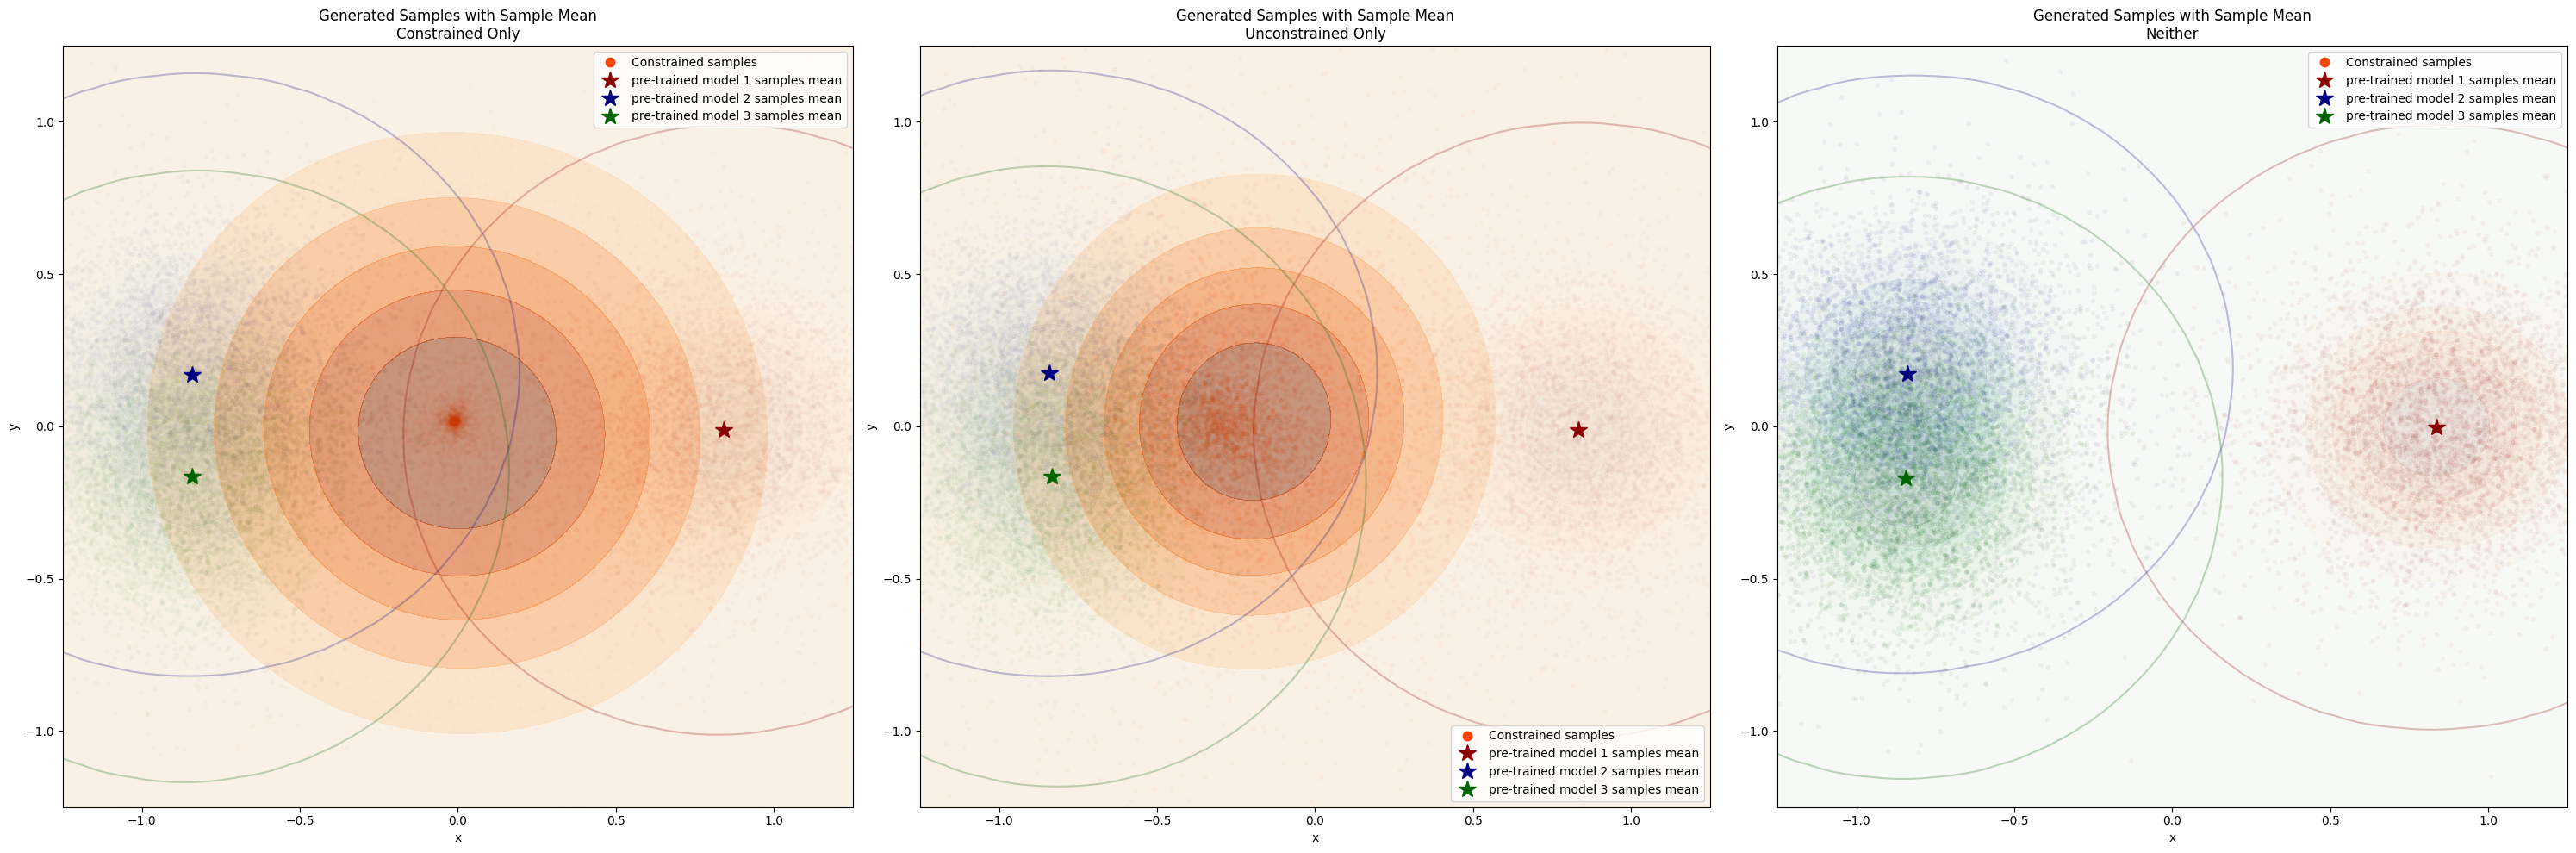

In [21]:
plt.figure(figsize=(30, 10))

# Common parameters
xlim = 1.25
ylim = 1.25
cmaps = ['Oranges', 'Blues', 'Greens']
col = ['darkred', 'navy', 'darkgreen']
grid = False
cmap_constrained = 'Greys'
col_constrained = 'orangered'
cmap_unconstrained = 'Greys'
col_unconstrained = 'orangered'

# Create three subplots
subplot_settings = [
    {'plot_const': True, 'plot_unconst': False, 'title': 'Constrained Only'},
    {'plot_const': False, 'plot_unconst': True, 'title': 'Unconstrained Only'},
    {'plot_const': False, 'plot_unconst': False, 'title': 'Neither'}
]

for subplot_idx, settings in enumerate(subplot_settings, 1):
    plt.subplot(1, 3, subplot_idx)
    
    plot_const = settings['plot_const']
    plot_unconst = settings['plot_unconst']

    for i, key in enumerate(['score_model_0', 'score_model_1', 'score_model_2']):
        score_model = score_models[key]
        batch_size = 5000
        

        x = np.linspace(-2, 2, 100)
        y = np.linspace(-2, 2, 100)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))

        images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()

        # Calculate and plot mean of generated samples
        sample_mean = np.mean(images, axis=0)
        plt.scatter(images[:, 0], images[:, 1], marker='.', color=col[i], alpha = 0.05)
        plt.grid(grid)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Generated Samples with Sample Mean\n{settings["title"]}')

        # Plot sample mean and covariance contours
        sample_cov = np.cov(images.T)

        # Plot mean point
        plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col[i], markersize=15, label='Sample Mean')

        # Plot contours of the sample distribution
        sample_rv = multivariate_normal(sample_mean, sample_cov)
        Z_sample = sample_rv.pdf(pos)
        
        # Create more contour levels with logarithmic spacing
        # levels = np.logspace(np.log10(Z_sample.max()/1000), np.log10(Z_sample.max()), 10)
        levels = np.linspace(Z_sample.min(), Z_sample.max(), 7)
        
        if subplot_idx == 0:
            # Fill the contour with color
            plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.15, cmap = cmaps[i], label='Sample Distribution')
        else:
            plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.15, cmap = cmaps[i], label='Sample Distribution')

        levels = np.logspace(np.log10(Z_sample.max()/1000), np.log10(Z_sample.max()), 1)
        plt.contour(X, Y, Z_sample, levels=levels, alpha=0.25, colors=col[i], label='Sample Distribution')

        plt.xlim(-xlim, xlim)
        plt.ylim(-ylim, ylim)

    #constrained
    if plot_const:
        score_model = score_models['score_model_constrained']
        batch_size = 5000

        x = np.linspace(-2, 2, 100)
        y = np.linspace(-2, 2, 100)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))

        images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()

        plt.scatter(images[:, 0], images[:, 1], marker='.', color=col_constrained, alpha = 0.02)

        # Calculate and plot mean of generated samples
        sample_mean = np.mean(images, axis=0)
        print(sample_mean)

        plt.grid(grid)
        plt.xlabel('x')
        plt.ylabel('y')

        # Plot sample mean and covariance contours
        sample_cov = np.cov(images.T)

        sample_rv = multivariate_normal(sample_mean, sample_cov)
        Z_sample = sample_rv.pdf(pos)
        levels = np.linspace(Z_sample.min(), Z_sample.max(), 7)
        print(levels)

        plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.5, cmap = 'Oranges', label='Sample Distribution')

    #unconstrained
    if plot_unconst:
        score_model = score_models['score_model_unconstrained']
        batch_size = 5000

        x = np.linspace(-2, 2, 100)
        y = np.linspace(-2, 2, 100)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))

        images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()

        plt.scatter(images[:, 0], images[:, 1], marker='.', color=col_unconstrained, alpha = 0.05)

        # Calculate and plot mean of generated samples
        sample_mean = np.mean(images, axis=0)
        print(sample_mean)

        plt.grid(grid)
        plt.xlabel('x')
        plt.ylabel('y')

        # Plot sample mean and covariance contours
        sample_cov = np.cov(images.T)

        sample_rv = multivariate_normal(sample_mean, sample_cov)
        Z_sample = sample_rv.pdf(pos)
        levels = np.linspace(Z_sample.min(), Z_sample.max(), 7)
        print(levels)

        plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.5, cmap = 'Oranges', label='Sample Distribution')

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='.', color=col_constrained, markersize=15, linestyle='none', label='Constrained samples')
    ]

    for i in range(3):
        legend_elements.append(plt.Line2D([0], [0], marker='*', color=col[i], markersize=15, linestyle='none', label=f'pre-trained model {i + 1} samples mean'))

    plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()



/tmp/ipykernel_528010/320223473.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col[i], markersize=15, label='Sample Mean')
/tmp/ipykernel_528010/320223473.py:49: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.5, cmap = cmaps[i], label='Sample Distribution')
/tmp/ipykernel_528010/320223473.py:52: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_sample, levels=levels, alpha=0.25, colors=col[i], label='Sample Distribution')


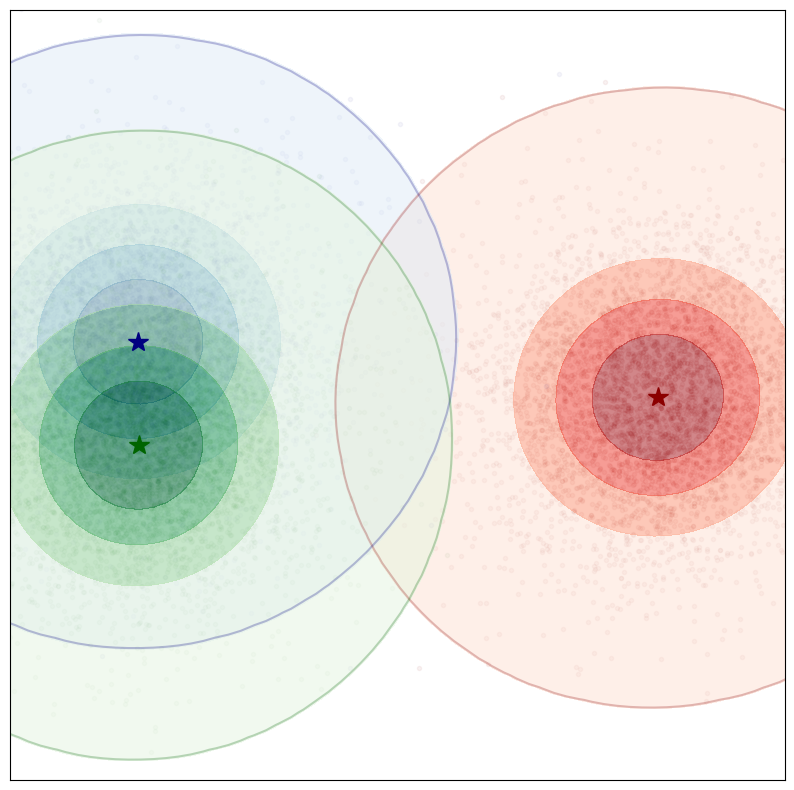

: 

In [76]:

plt.figure(figsize=(10, 10))

# Common parameters
xlim = 1.25
ylim = 1.25
cmaps = ['Reds', 'Blues', 'Greens']
col = ['darkred', 'navy', 'darkgreen']
grid = False
cmap_constrained = 'Greys'
col_constrained = 'orangered'
cmap_unconstrained = 'Greys'
col_unconstrained = 'orangered'

for i, key in enumerate(['score_model_0', 'score_model_1', 'score_model_2']):
    score_model = score_models[key]
    batch_size = 5000
    

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    images = (sample_images(score_model, noise_scheduler, batch_size, num_inference_steps = config.T)).detach().cpu().numpy()

    # Calculate and plot mean of generated samples
    sample_mean = np.mean(images, axis=0)
    plt.scatter(images[:, 0], images[:, 1], marker='.', color=col[i], alpha = 0.05 - i*0.01)
    plt.grid(grid)
    plt.xticks([])
    plt.yticks([])

    # Plot sample mean and covariance contours
    sample_cov = np.cov(images.T)

    # Plot mean point
    plt.plot(sample_mean[0], sample_mean[1], 'r*', c = col[i], markersize=15, label='Sample Mean')

    # Plot contours of the sample distribution
    sample_rv = multivariate_normal(sample_mean, sample_cov)
    Z_sample = sample_rv.pdf(pos)
    
    # Create more contour levels with logarithmic spacing
    # levels = np.logspace(np.log10(Z_sample.max()/1000), np.log10(Z_sample.max()), 10)
    levels = np.linspace(Z_sample.min() + 0.002, Z_sample.max(), 5)
    

    # Fill the contour with color
    plt.contourf(X, Y, Z_sample, levels=levels, alpha=0.5, cmap = cmaps[i], label='Sample Distribution')

    levels = np.logspace(np.log10(Z_sample.max()/1000), np.log10(Z_sample.max()), 1)
    plt.contour(X, Y, Z_sample, levels=levels, alpha=0.25, colors=col[i], label='Sample Distribution')

    plt.xlim(-xlim, xlim)
    plt.ylim(-ylim, ylim)

In [14]:
#Annealed sampling tests
# unets = score_models
# unet = unets[1]
# unet.eval()

# scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02, clip_sample=False)



# #ULA 
# # increase the number of Langevin MCMC steps run to sample between intermediate distributions
# # more steps improves sampling quality
# la_steps = 10
# la_step_sizes = scheduler.betas * 2


# sampler = AnnealedULASampler(config.T, la_steps, la_step_sizes, gradient)

# images = sample_images_ddpm(unet, scheduler, batch_size = 512, num_inference_steps = config.T, sampler = sampler)
# images = images.detach().cpu().numpy()

In [27]:
def mix_score_models(unets, weights):
    """
    Creates a function that mixes the outputs of two score models according to weights.
    
    Args:
        unet1: First score model
        unet2: Second score model 
        weights: Tensor of mixing weights
        
    Returns:
        Function that takes input x and timestep t and returns weighted mixture of model outputs
    """
    def mixed_score_fn(x, t):
        # Get outputs from both models
        scores = [unet(x, t) for unet in unets]

        w = weights.to(x.device)
        # Weighted sum of the outputs
        mixed_score = sum(w[i] * scores[i] for i in range(len(unets)))
        
        return mixed_score
        
    return mixed_score_fn



In [ ]:
score_mix = mix_score_models(score_models['score_model_0'], score_models['score_model_1'], torch.tensor([0.9, 0.1]))

KL_list = []

KL_per_step, KL_total = compute_KL(score_mix, score_models['score_model_0'], score_models['score_model_product_09_01'], noise_scheduler, batch_size = 128, num_batches = 4, num_inference_steps = config.T, sampler = sampler)
plt.plot(reversed(noise_scheduler.timesteps), KL_per_step.detach().cpu().numpy())
plt.xlabel('t')
plt.ylabel('score matching error')

KL_list.append(KL_per_step)

print(KL_total)

KL_per_step, KL_total = compute_KL(score_models['score_model_product_09_01'], score_models['score_model_0'], score_models['score_model_product_09_01'], noise_scheduler, batch_size = 128, num_batches = 4, num_inference_steps = config.T, sampler = sampler)
plt.plot(reversed(noise_scheduler.timesteps), KL_per_step.detach().cpu().numpy())
plt.xlabel('t')
plt.ylabel('score matching error')

KL_list.append(KL_per_step)
print(KL_total)



In [ ]:
unet = mix_score_models(score_models['score_model_0'], score_models['score_model_1'], torch.tensor([0.9, 0.1]))
# unet = score_models['score_model_0']

scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02, clip_sample=False)




#ULA 
# increase the number of Langevin MCMC steps run to sample between intermediate distributions
# more steps improves sampling quality
la_steps = 10
la_step_sizes = scheduler.betas * 2


sampler = AnnealedULASampler(config.T, la_steps, la_step_sizes, gradient)

# Sample multiple batches and combine
num_batches = 10
all_samples = []

for _ in tqdm(range(num_batches)):
    batch_samples = sample_images_ddpm(unet, scheduler, batch_size=256, num_inference_steps=config.T, sampler=sampler)
    all_samples.append(batch_samples.detach().cpu().numpy())

all_samples = np.concatenate(all_samples, axis=0)

# Create 2D histogram plot
plt.figure(figsize=(10, 10))
plt.hist2d(all_samples[:, 0], all_samples[:, 1], bins=100, density=True, cmap='Greys')
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.title('2D Histogram of Samples')

#plot the gaussians
radius = 1.0  # radius of the circle
num_gaussians = 6  # number of points on the circle
theta = torch.linspace(0, 2*torch.pi, num_gaussians+1)[:-1]  # angles, exclude last point to avoid duplicate
means = radius * torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
variance = 0.010  # variance for each Gaussian
variances = torch.ones(num_gaussians) * variance
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
for i in range(len(means)):
    mean = means[i].numpy()
    cov = variances[i] * np.eye(2)
    rv = multivariate_normal(mean, cov)
    
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z, levels=5, alpha=0.5, colors='blue')

# Fit a Gaussian to the samples and plot
mean = np.mean(all_samples, axis=0)
cov = np.cov(all_samples.T)

# Plot the mean as a point
plt.scatter(mean[0], mean[1], color='red', marker='x', s=25, label='Mean')

# Plot covariance contours
x, y = np.mgrid[-1.25:1.25:.01, -1.25:1.25:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
plt.contour(x, y, rv.pdf(pos), levels=5, colors='red', linewidths=2, label='Density Contours', alpha = 0.5)
plt.legend()


plt.show()


In [ ]:
# Create a TensorDataset from all_samples
dataset_true_product = torch.utils.data.TensorDataset(torch.tensor(all_samples))

# Create DataLoader with batch size of 128
dataloader_true_product = torch.utils.data.DataLoader(
    dataset_true_product,
    batch_size=128,
    shuffle=True
)

# Sample a batch from the dataloader
train_features = next(iter(dataloader_true_product))


print(train_features)

train_features = train_features[0].cuda()  # Move to GPU and get first element since TensorDataset wraps in tuple

print(train_features.shape)


In [ ]:
# Create directory for saved models if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save each score model
for i, model in enumerate(score_models):
    save_path = f'saved_models/score_model_{i}.pt'
    torch.save(model.state_dict(), save_path)
    print(f"Saved model {i} to {save_path}")



In [ ]:
batch_size = 22000

image = torch.randn((batch_size, 2)).cuda()

errors = torch.zeros(config.T)
coeffs = torch.zeros(config.T)
my_coeffs = torch.zeros(config.T)

model_untrained = ResnetDiffusionModel(
    n_steps=config.T,           # Number of diffusion timesteps
    n_layers=4,            # Number of residual layers
    x_dim=2,               # Data dimensionality
    h_dim=128,             # Hidden dimension
    emb_dim=32,            # Embedding dimension
    widen=2,               # Multiplier for inner layer width
    emb_type='learned'     # Type of time embedding
).cuda()

models = [model_untrained, score_models[0]]


for t in noise_scheduler.timesteps:
    alpha_bar_t = noise_scheduler.alphas_cumprod[t]
    beta_t = noise_scheduler.betas[t] 
    coeffs[t.item()] = beta_t**2 / (2 * (1-beta_t) * (alpha_bar_t))

    my_coeffs[t.item()] = t.item()/config.T


    model_outputs = []
    for unet in models:
        with torch.no_grad():
            model_output = unet(
                image, 
                t*torch.ones(batch_size, dtype=torch.long, device=image.device)
            )

        model_outputs.append(model_output)
        
    error =  torch.sum((model_outputs[0] - model_outputs[1])**2)/batch_size
    image = noise_scheduler.step(model_outputs[0], t, image).prev_sample

    errors[t.item()] = error.item()


plt.plot(errors)
plt.grid(True)
plt.show()


  

In [ ]:

for weight1 in [1.0]:
    weights = torch.tensor([weight1, 1-weight1])
    samples = sample_composition(score_models, weights, noise_scheduler, batch_size = 5000, num_inference_steps = config.T)
    visualize_generated_samples(score_models[0], noise_scheduler, config, samples = samples)

In [ ]:
#ONE MODEL PER GAUSSIAN

#(EQUAL VARIANCE)

%matplotlib inline
from accelerate import notebook_launcher

config.num_epochs = 200
config.batches_per_epoch = 1    
config.save_plot_epochs = 100
config.lr_primal = 0.01
config.wandb_logging = True
config.T = 100
config.primal_batch_size = 512

# score_models = []

means = [torch.tensor([-1.0, -0.2])]
radius = 1.0
variances = [0.05]

for i in range(len(means)):

    score = ResnetDiffusionModel(
        n_steps=config.T,           # Number of diffusion timesteps
        n_layers=4,            # Number of residual layers
        x_dim=2,               # Data dimensionality
        h_dim=128,             # Hidden dimension
        emb_dim=32,            # Embedding dimension
        widen=2,               # Multiplier for inner layer width
        emb_type='learned'     # Type of time embedding
    )

    mean = means[i]
    cov = variances[i]*torch.eye(2)
    dataset = GMMDataset(mean[None, :], cov[None, :], num_samples = 1000)


    # train_dataloader = DataLoader(dataset, batch_size=config.primal_batch_size, shuffle=True)
    train_dataloader = DataLoader(
    dataset,
    batch_size=config.primal_batch_size,
    shuffle=True
)


    noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02, clip_sample=False)
    noise_scheduler.set_timesteps(config.T)

    optimizer = torch.optim.AdamW(score.parameters(), lr=config.lr_primal)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(config.num_epochs)
    )

    args = (config, score, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
    # notebook_launcher(train_loop, args, num_processes=1)
    train_loop(config, score, noise_scheduler, optimizer, train_dataloader, lr_scheduler, means, variances)

    score_models.append(score)


In [ ]:
#ring of Gaussians

%matplotlib inline
from accelerate import notebook_launcher

config.num_epochs = 1000
config.batches_per_epoch = 1  
config.save_plot_epochs = 100
config.lr_primal = 0.01
config.wandb_logging = True
config.T = 100
config.primal_batch_size = 512

score_models = []


# Generate points on a circle
radius = 1.0  # radius of the circle
num_gaussians = 6  # number of points on the circle
theta = torch.linspace(0, 2*torch.pi, num_gaussians+1)[:-1]  # angles, exclude last point to avoid duplicate
means = radius * torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
variance = 0.010  # variance for each Gaussian
variances = torch.ones(num_gaussians) * variance
covs = torch.stack([variance*torch.eye(2)]*num_gaussians, dim=0)






score = ResnetDiffusionModel(
    n_steps=config.T,           # Number of diffusion timesteps
    n_layers=4,            # Number of residual layers
    x_dim=2,               # Data dimensionality
    h_dim=128,             # Hidden dimension
    emb_dim=32,            # Embedding dimension
    widen=2,               # Multiplier for inner layer width
    emb_type='learned'     # Type of time embedding
)


dataset = GMMDataset(means, covs, num_samples = 10000)


train_dataloader = DataLoader(dataset, batch_size=config.primal_batch_size, shuffle=True)

noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02, clip_sample=False)
noise_scheduler.set_timesteps(config.T)

optimizer = torch.optim.AdamW(score.parameters(), lr=config.lr_primal)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(config.num_epochs),
)

args = (config, score, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
# notebook_launcher(train_loop, args, num_processes=1)
train_loop(config, score, noise_scheduler, optimizer, train_dataloader, lr_scheduler, means, variances)

score_models.append(score)


In [54]:
#CORRECTED CONSTRAINED TRAIN LOOP
def constrained_train_loop_corrected(config, model, noise_scheduler, optimizer, pre_trained_models, lr_scheduler, init_mus = None, b = None):

    
    # Create a figure with 10 subplots (2 rows, 5 columns)
    # fig, axes = plt.subplots(int(config.num_epochs/config.save_plot_epochs//5), 5, figsize=(15, 3*int(config.num_epochs/config.save_plot_epochs//5)))
    # axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Initialize the figure
    
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb" if config.wandb_logging else None,
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if config.wandb_logging:
        accelerator.init_trackers(
                project_name="simple_constrained_diffusion_tests",
                config=config,
            )
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, lr_scheduler = accelerator.prepare(
        model, optimizer, lr_scheduler
    )
    

    #Nc is the number of constraints here
    Nc = len(pre_trained_models)
    

    if init_mus is not None:
        mu = init_mus
    else:
        mu = 1/Nc*torch.ones(Nc, requires_grad = False).to(accelerator.device)
    
    if b is not None:
        b = b
    else:
        b = torch.zeros(Nc, requires_grad = False).to(accelerator.device)
    

    # Now you train the model
    
    # progress_bar = tqdm(total=config.num_epochs, disable=not accelerator.is_local_main_process)
    # progress_bar.set_description("Training Progress")

    la_steps = 10
    la_step_sizes = noise_scheduler.betas * 2


    sampler = AnnealedULASampler(config.T, la_steps, la_step_sizes, gradient)
        
    
    image_shape = (config.primal_batch_size, 2) 
    for epoch in range(config.num_epochs):

        print("epoch ", epoch)

        unet = mix_score_models(pre_trained_models, mu)
        #sample true images from the correct product distribution
        noise_scheduler.set_timesteps(config.num_inference_steps)
        true_samples = sample_images_ddpm(unet, noise_scheduler, batch_size=config.primal_batch_size, num_inference_steps=config.num_inference_steps, sampler=sampler)
        
        
        for step in range(config.batches_per_epoch):
            noise_scheduler.set_timesteps(config.T)
             
            Clean_images = true_samples.to(accelerator.device)
            Noises = torch.randn(Clean_images.shape, device = Clean_images.device)
            Batch_sizes = Clean_images.shape[0]
            Timesteps = torch.randint(
                        0, config.T, (Batch_sizes,), device = Clean_images.device,
                        dtype = torch.int64
                    )
            Noisy_images = noise_scheduler.add_noise(Clean_images, Noises, Timesteps)


            with accelerator.accumulate(model):

                Noise_preds = model(Noisy_images.unsqueeze(0), Timesteps)


                Losses = F.mse_loss(Noise_preds.squeeze(), Noises)

                accelerator.backward(Losses)
                
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
        KLs = []
        for pre_trained_model in pre_trained_models:
            _, KL = compute_KL(model, pre_trained_model, unet, noise_scheduler, batch_size = 64, num_batches = 1, num_inference_steps = config.num_inference_steps, sampler = sampler, samples = true_samples)
            KLs += [KL]
        ############### DUAL STEP START #############

        if (epoch + 1)%config.primal_per_dual == 0:
            
            lr_dual = config.lr_dual
            l = torch.tensor(KLs, requires_grad = False).to(mu.device)
            b = b.to(mu.device)
            grad = lr_dual*(l - b)
            
            if torch.linalg.norm(grad).detach() != 0:   
                # GD step
                mu = (mu + grad).detach()
                # make sure mu is in the simplex
                mu = project_onto_simplex(mu)

    
        ################ DUAL STEP END ###############
               
        if config.wandb_logging:
            accelerator.log({"Loss": Losses}, step = epoch)
            
            for k in range(mu.shape[0]):
                accelerator.log({"Dkl " + str(k + 1): KLs[k]}, step = epoch)
                accelerator.log({"mu " + str(k + 1): mu[k]}, step = epoch)

            lr = lr_scheduler.get_last_lr()[0]
            accelerator.log({"lr": lr}, step = epoch)
                
        # progress_bar.update(1)
            
        if epoch%config.save_plot_epochs == 0:
            save_path = f'saved_models/score_model_{config.save_model_header}.pt'
            torch.save(model.state_dict(), save_path)
            print(f"Saved model to {save_path}")

            fig = visualize_generated_samples(model, noise_scheduler, config)

            if config.wandb_logging:
                accelerator.log({"samples": wandb.Image(fig)}, step=epoch)

        

            
            
    if accelerator.is_main_process and hasattr(accelerator, "trackers") and accelerator.trackers:
        accelerator.end_training()
        print("Training complete")



In [62]:
#FIT CONSTRAINED
%matplotlib inline
from IPython.display import clear_output
from itertools import cycle
from accelerate import notebook_launcher

config.num_epochs = 1000
config.batches_per_epoch = 1   
config.save_plot_epochs = 10
config.lr_primal = 0.0001
config.lr_dual = 0.001
config.primal_per_dual = 2
config.T = 100
config.primal_batch_size = 128
config.wandb_logging = True
config.num_inference_steps = 10
config.save_model_header = "constrained"

config.gradient_accumulation_steps = 1



noise_scheduler = DDIMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02,clip_sample=False)
noise_scheduler.set_timesteps(config.T)



model = ResnetDiffusionModel(
    n_steps=config.T,           # Number of diffusion timesteps
    n_layers=4,            # Number of residual layers
    x_dim=2,               # Data dimensionality
    h_dim=128,             # Hidden dimension
    emb_dim=32,            # Embedding dimension
    widen=2,               # Multiplier for inner layer width
    emb_type='learned'     # Type of time embedding
)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr_primal)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(config.batches_per_epoch *config.num_epochs),
)



pre_trained_models = score_models
for pre_trained_model in pre_trained_models:
    pre_trained_model.eval()
    pre_trained_model.requires_grad_ = False
init_mus = torch.ones(len(pre_trained_models), requires_grad = False)/len(pre_trained_models)
args = (config, model, noise_scheduler, optimizer, pre_trained_models, lr_scheduler, init_mus)

In [60]:
def compute_KL(score_1, score_2, score_prod_true, noise_scheduler, batch_size = 32, num_batches = 1, num_inference_steps = config.T, sampler = None, samples = None):
    device = torch.device('cuda')
    errors = torch.zeros(num_inference_steps, requires_grad = False).to(device)

    noise_scheduler.set_timesteps(num_inference_steps)

    #sample from the true product using MCMC (or reverse diffusion)

    if samples is None:
        batch_samples = sample_images_ddpm(score_prod_true, noise_scheduler, batch_size=batch_size, num_inference_steps=config.T, sampler=sampler)
    else:
        batch_samples = samples

    init_samples = batch_samples.clone()
    noise = torch.randn_like(batch_samples)
    #sample correct forward trajectories
    # print(noise_scheduler.timesteps)
    # print(noise_scheduler.timesteps.shape)

    timesteps = torch.linspace(1, 99, num_inference_steps).long()
    for i,t in enumerate(timesteps):
        with torch.no_grad():
            batch_samples = noise_scheduler.add_noise(init_samples, noise, t)
            # if t%10 == 0:
            #     plt.scatter((batch_samples[:, 0]).detach().cpu().numpy(), (batch_samples[:, 1]).detach().cpu().numpy(), alpha = 0.2)
            #     plt.xlim(-1.25, 1.25)
            #     plt.ylim(-1.25, 1.25)
            #     plt.show()

            pred_1 = score_1(batch_samples.to(device), t.to(device))
            pred_2 = score_2(batch_samples.to(device), t.to(device))

            error = torch.sum((pred_1 - pred_2)**2)/batch_size
            errors[i] += error.item()
            #sample forward noise
                
                

    errors = errors/num_batches

    return errors, torch.sum(errors)



Launching training on one GPU.


/tmp/ipykernel_608193/1880618692.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  alphas_cumprod = np.cumprod(np.array(alphas))


epoch  0


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.84it/s]
/tmp/ipykernel_608193/2655948317.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_608193/2655948317.py:104: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_sample, levels=5, alpha=0.5, colors='red', linestyles='dashed', label='Sample Distribution')


Saved model to saved_models/score_model_constrained.pt
epoch  1


Sampling: 100%|██████████| 10/10 [00:00<00:00, 20.22it/s]


epoch  2


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.55it/s]


epoch  3


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.73it/s]


epoch  4


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.46it/s]


epoch  5


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.71it/s]


epoch  6


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.47it/s]


epoch  7


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s]


epoch  8


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.33it/s]


epoch  9


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.54it/s]


epoch  10


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.33it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  11


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.79it/s]


epoch  12


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.37it/s]


epoch  13


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.55it/s]


epoch  14


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.04it/s]


epoch  15


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.60it/s]


epoch  16


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s]


epoch  17


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.90it/s]


epoch  18


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.82it/s]


epoch  19


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.59it/s]


epoch  20


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.96it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  21


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.66it/s]


epoch  22


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.71it/s]


epoch  23


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.36it/s]


epoch  24


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.63it/s]


epoch  25


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.94it/s]


epoch  26


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.19it/s]


epoch  27


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.13it/s]


epoch  28


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.14it/s]


epoch  29


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.44it/s]


epoch  30


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.01it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  31


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.48it/s]


epoch  32


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s]


epoch  33


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.40it/s]


epoch  34


Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.89it/s]


epoch  35


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s]


epoch  36


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.40it/s]


epoch  37


Sampling: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s]


epoch  38


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.35it/s]


epoch  39


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s]


epoch  40


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.41it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  41


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.08it/s]


epoch  42


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.99it/s]


epoch  43


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.49it/s]


epoch  44


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.46it/s]


epoch  45


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s]


epoch  46


Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.92it/s]


epoch  47


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.49it/s]


epoch  48


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.47it/s]


epoch  49


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.54it/s]


epoch  50


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.52it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  51


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.71it/s]


epoch  52


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.21it/s]


epoch  53


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.50it/s]


epoch  54


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.44it/s]


epoch  55


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.48it/s]


epoch  56


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.29it/s]


epoch  57


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.36it/s]


epoch  58


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.23it/s]


epoch  59


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.34it/s]


epoch  60


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.32it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  61


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.74it/s]


epoch  62


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s]


epoch  63


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.20it/s]


epoch  64


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.47it/s]


epoch  65


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.17it/s]


epoch  66


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s]


epoch  67


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.51it/s]


epoch  68


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.99it/s]


epoch  69


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.46it/s]


epoch  70


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.38it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  71


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.66it/s]


epoch  72


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.85it/s]


epoch  73


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.90it/s]


epoch  74


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s]


epoch  75


Sampling: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


epoch  76


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.26it/s]


epoch  77


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.57it/s]


epoch  78


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.98it/s]


epoch  79


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s]


epoch  80


Sampling: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  81


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.35it/s]


epoch  82


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.13it/s]


epoch  83


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.78it/s]


epoch  84


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.03it/s]


epoch  85


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s]


epoch  86


Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.86it/s]


epoch  87


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.55it/s]


epoch  88


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s]


epoch  89


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s]


epoch  90


Sampling: 100%|██████████| 10/10 [00:00<00:00, 18.38it/s]


Saved model to saved_models/score_model_constrained.pt
epoch  91


Sampling: 100%|██████████| 10/10 [00:00<00:00, 19.23it/s]


epoch  92


Sampling:  20%|██        | 2/10 [00:00<00:00, 15.65it/s]


KeyboardInterrupt: 

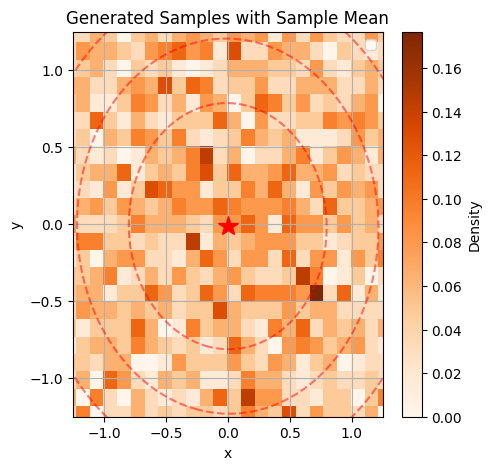

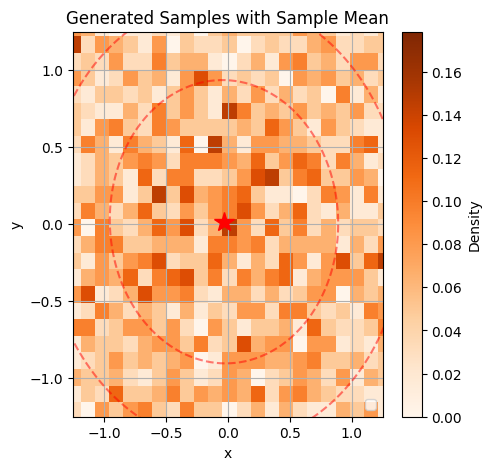

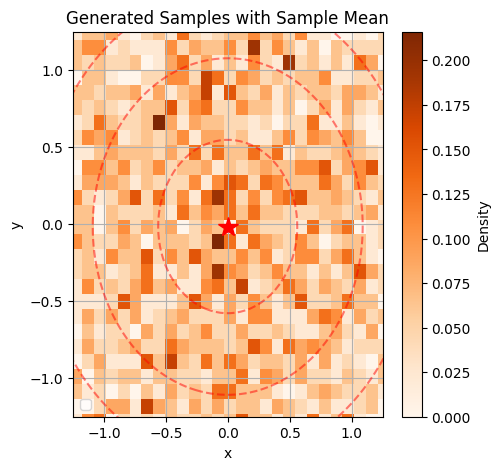

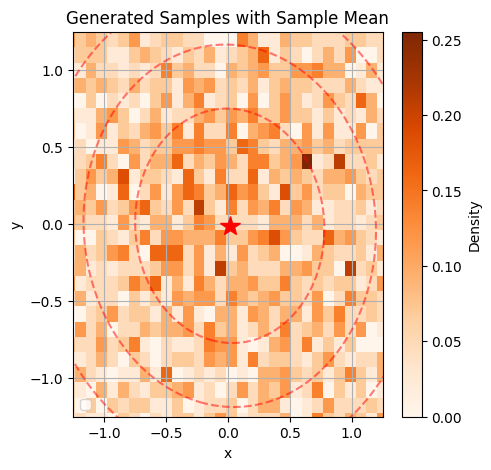

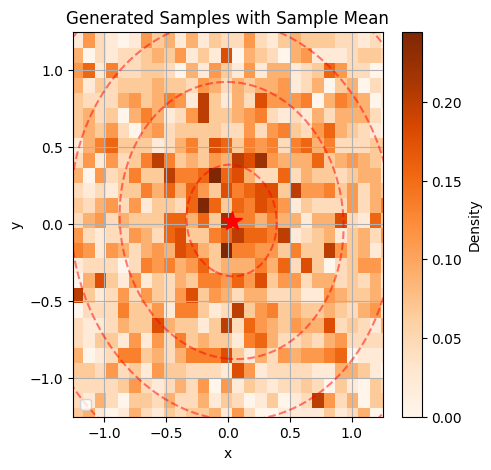

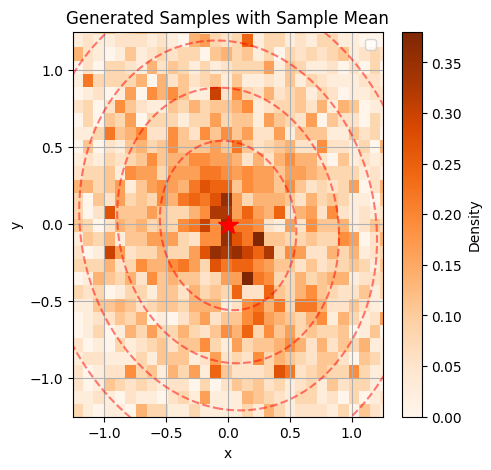

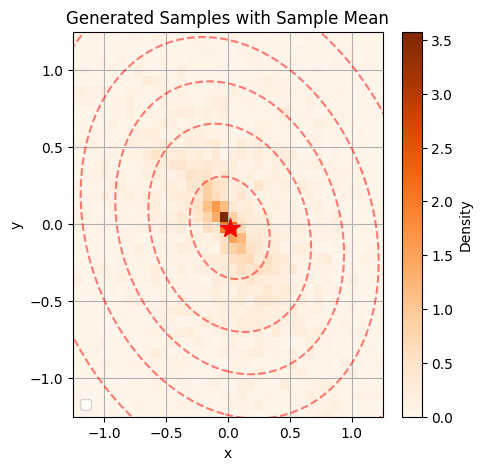

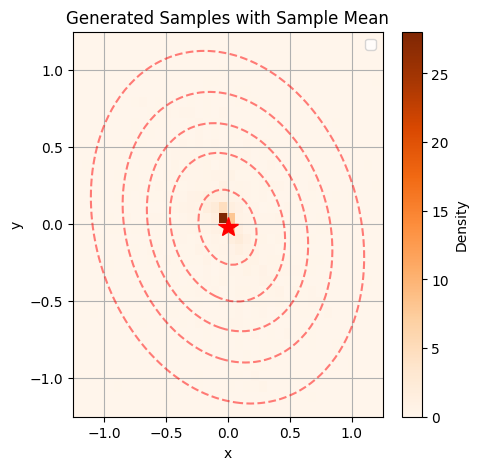

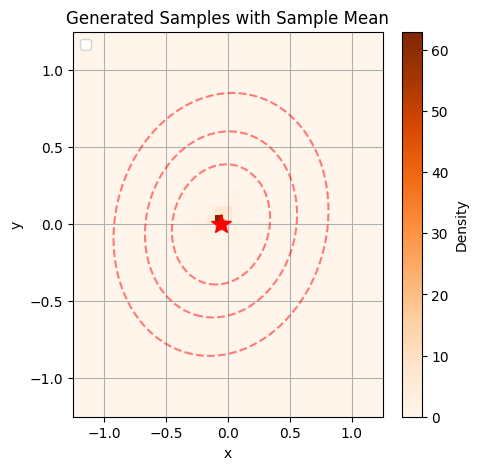

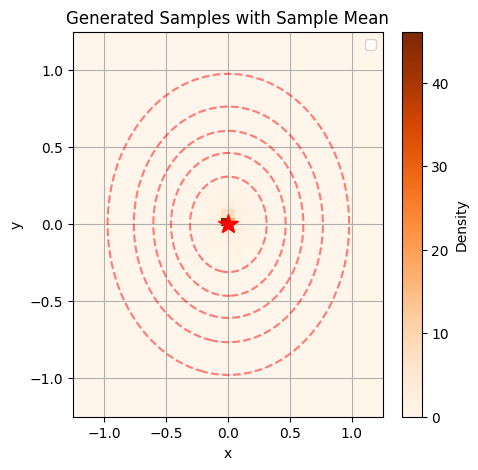

In [63]:
notebook_launcher(constrained_train_loop_corrected, args, num_processes=1)

DIFFERENT VARIANCE

In [ ]:
%matplotlib inline
from accelerate import notebook_launcher

config.num_epochs = 20
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.wandb_logging = True
config.T = 20
config.primal_batch_size = 1024

angles = torch.tensor([0.0, torch.pi])
radius = 1.0
variance = [0.025, 0.5]

gmm_models_asym = []
for i in [0, 1]:
    gmm_model = ResnetDiffusionModel(
        n_steps=100,           # Number of diffusion timesteps
        n_layers=4,            # Number of residual layers
        x_dim=2,               # Data dimensionality
        h_dim=128,             # Hidden dimension
        emb_dim=32,            # Embedding dimension
        widen=2,               # Multiplier for inner layer width
        emb_type='learned'     # Type of time embedding
    )



    mean = radius*torch.tensor([torch.cos(angles[i]), torch.sin(angles[i])])
    cov = variance[i]*torch.eye(2)
    dataset = GMMDataset(radius*mean[None, :], cov[None, :], num_samples = 1000)


    train_dataloader = DataLoader(dataset, batch_size=config.primal_batch_size, shuffle=True)

    noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.05, clip_sample=False)

    optimizer = torch.optim.AdamW(gmm_model.parameters(), lr=config.lr_primal)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * config.num_epochs),
    )

    args = (config, gmm_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
    notebook_launcher(train_loop, args, num_processes=1)
    gmm_models_asym.append(gmm_model)


In [14]:
#Run the training loop
%matplotlib inline
from IPython.display import clear_output
from itertools import cycle
from accelerate import notebook_launcher

config.num_epochs = 20
config.batches_per_epoch = 1     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.001
config.wandb_logging = True
config.T = 100
config.primal_batch_size = 1024


# Generate means spaced by 45 degrees

noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.05,clip_sample=False)

mu1 = 0.5

init_mus = torch.ones(len(gmm_models_asym), requires_grad = False)/len(gmm_models_asym)

model_asym = ResnetDiffusionModel(
    n_steps=100,           # Number of diffusion timesteps
    n_layers=4,            # Number of residual layers
    x_dim=2,               # Data dimensionality
    h_dim=128,             # Hidden dimension
    emb_dim=32,            # Embedding dimension
    widen=2,               # Multiplier for inner layer width
    emb_type='learned'     # Type of time embedding
)

optimizer = torch.optim.AdamW(model_asym.parameters(), lr=config.lr_primal)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(config.batches_per_epoch * config.T * config.num_epochs),
)

for m in gmm_models_asym:
    m.eval()
    m.requires_grad_ = False
distributions = gmm_models_asym

args = (config, model_asym, noise_scheduler, optimizer, distributions, lr_scheduler, init_mus)

In [ ]:
run_dict = notebook_launcher(constrained_train_loop, args, num_processes=1)

THREE DISTRIBUTIONS

In [ ]:
%matplotlib inline
from accelerate import notebook_launcher

config.num_epochs = 15
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.01
config.wandb_logging = True
config.T = 25
config.primal_batch_size = 1024


radius = 2.0
num_means = 12
angles = torch.linspace(0, 2 * torch.pi, num_means + 1)[:-1]
means_circle = radius*torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)
# Generate equal covariances 
covs_circle = torch.stack([0.025*torch.eye(2)]*num_means, dim=0)

gmm_models = []
for i in [0, 4, 8]:
    gmm_model = ResnetDiffusionModel(
        n_steps=config.T,           # Number of diffusion timesteps
        n_layers=4,            # Number of residual layers
        x_dim=2,               # Data dimensionality
        h_dim=128,             # Hidden dimension
        emb_dim=32,            # Embedding dimension
        widen=2,               # Multiplier for inner layer width
        emb_type='learned'     # Type of time embedding
    )


    optimizer = torch.optim.AdamW(gmm_model.parameters(), lr=config.lr_primal)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * config.num_epochs),
    )
    dataset = GMMDataset(means_circle[i][None, :], covs_circle[i][None, :], num_samples = 1000)


    train_dataloader = DataLoader(dataset, batch_size=config.primal_batch_size, shuffle=True)

    noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02, clip_sample=False)
    noise_scheduler.set_timesteps(config.T)

    args = (config, gmm_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
    notebook_launcher(train_loop, args, num_processes=1)
    gmm_models.append(gmm_model)


In [17]:
#Run the training loop
%matplotlib inline
from IPython.display import clear_output
from itertools import cycle
from accelerate import notebook_launcher

config.num_epochs = 20
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.001
config.wandb_logging = True
config.T = 5
config.primal_batch_size = 512


# Generate means spaced by 45 degrees

noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.02,clip_sample=False)
noise_scheduler.set_timesteps(config.T)

mu1 = 0.5

init_mus = torch.ones(len(gmm_models), requires_grad = False)/len(gmm_models)

model = ResnetDiffusionModel(
    n_steps=config.T,           # Number of diffusion timesteps
    n_layers=4,            # Number of residual layers
    x_dim=2,               # Data dimensionality
    h_dim=128,             # Hidden dimension
    emb_dim=32,            # Embedding dimension
    widen=2,               # Multiplier for inner layer width
    emb_type='learned'     # Type of time embedding
)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr_primal)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(config.batches_per_epoch * config.T * config.num_epochs),
)

for m in gmm_models:
    m.eval()
    m.requires_grad_ = False
distributions = gmm_models

args = (config, model, noise_scheduler, optimizer, distributions, lr_scheduler, init_mus)



In [ ]:
notebook_launcher(constrained_train_loop, args, num_processes=1)


In [ ]:
%matplotlib inline
from accelerate import notebook_launcher

config.num_epochs = 15
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.01
config.wandb_logging = True
config.T = 25
config.primal_batch_size = 1024


radius = 2.0
num_means = 12
angles = torch.linspace(0, 2 * torch.pi, num_means + 1)[:-1]
means_circle = radius*torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)
# Generate equal covariances 
covs_circle = torch.stack([0.025*torch.eye(2)]*num_means, dim=0)

gmm_models = []
for i in [0, 4, 8]:
    gmm_model = ResnetDiffusionModel(
        n_steps=config.T,           # Number of diffusion timesteps
        n_layers=4,            # Number of residual layers
        x_dim=2,               # Data dimensionality
        h_dim=128,             # Hidden dimension
        emb_dim=32,            # Embedding dimension
        widen=2,               # Multiplier for inner layer width
        emb_type='learned'     # Type of time embedding
    )


    dataset = GMMDataset(means_circle[i][None, :], covs_circle[i][None, :], num_samples = 1000)


    train_dataloader = DataLoader(dataset, batch_size=config.primal_batch_size, shuffle=True)


    optimizer = torch.optim.AdamW(gmm_model.parameters(), lr=config.lr_primal)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * config.num_epochs),
    )

    noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.05, clip_sample=False)
    noise_scheduler.set_timesteps(config.T)

    args = (config, gmm_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
    notebook_launcher(train_loop, args, num_processes=1)
    gmm_models.append(gmm_model)


In [ ]:
#Run the training loop
%matplotlib inline
from IPython.display import clear_output
from itertools import cycle
from accelerate import notebook_launcher

config.num_epochs = 20
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.001
config.wandb_logging = True
config.T = 100
config.primal_batch_size = 512


# Generate means spaced by 45 degrees

noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.05,clip_sample=False)

mu1 = 0.5

init_mus = torch.ones(len(gmm_models), requires_grad = False)/len(gmm_models)

model = ResnetDiffusionModel(
    n_steps=100,           # Number of diffusion timesteps
    n_layers=4,            # Number of residual layers
    x_dim=2,               # Data dimensionality
    h_dim=128,             # Hidden dimension
    emb_dim=32,            # Embedding dimension
    widen=2,               # Multiplier for inner layer width
    emb_type='learned'     # Type of time embedding
)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr_primal)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(config.batches_per_epoch * config.T * config.num_epochs),
)

for m in gmm_models:
    m.eval()
    m.requires_grad_ = False
distributions = gmm_models

args = (config, model, noise_scheduler, optimizer, distributions, lr_scheduler, init_mus)

notebook_launcher(constrained_train_loop, args, num_processes=1)

In [ ]:
%matplotlib inline
from accelerate import notebook_launcher

config.num_epochs = 20
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.01
config.wandb_logging = True
config.T = 100
config.primal_batch_size = 1024


radius = 2.0
num_means = 12
angles = torch.linspace(0, 2 * torch.pi, num_means + 1)[:-1]
means_circle = radius*torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)
# Generate equal covariances 
covs_circle = torch.stack([0.025*torch.eye(2)]*num_means, dim=0)

gmm_models = []
for i in [0, 6, 7]:
    gmm_model = ResnetDiffusionModel(
        n_steps=100,           # Number of diffusion timesteps
        n_layers=4,            # Number of residual layers
        x_dim=2,               # Data dimensionality
        h_dim=128,             # Hidden dimension
        emb_dim=32,            # Embedding dimension
        widen=2,               # Multiplier for inner layer width
        emb_type='learned'     # Type of time embedding
    )


    optimizer = torch.optim.AdamW(gmm_model.parameters(), lr=config.lr_primal)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * config.num_epochs),
    )
    dataset = GMMDataset(means_circle[i][None, :], covs_circle[i][None, :], num_samples = 1000)


    train_dataloader = DataLoader(dataset, batch_size=config.primal_batch_size, shuffle=True)

    noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.05, clip_sample=False)

    args = (config, gmm_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
    notebook_launcher(train_loop, args, num_processes=1)
    gmm_models.append(gmm_model)


In [ ]:
#Run the training loop
%matplotlib inline
from IPython.display import clear_output
from itertools import cycle
from accelerate import notebook_launcher

config.num_epochs = 20
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.001
config.wandb_logging = True
config.T = 100
config.primal_batch_size = 512


# Generate means spaced by 45 degrees

noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.05,clip_sample=False)

mu1 = 0.5

init_mus = torch.ones(len(gmm_models), requires_grad = False)/len(gmm_models)

model = ResnetDiffusionModel(
    n_steps=100,           # Number of diffusion timesteps
    n_layers=4,            # Number of residual layers
    x_dim=2,               # Data dimensionality
    h_dim=128,             # Hidden dimension
    emb_dim=32,            # Embedding dimension
    widen=2,               # Multiplier for inner layer width
    emb_type='learned'     # Type of time embedding
)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr_primal)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(config.batches_per_epoch * config.T * config.num_epochs),
)

for m in gmm_models:
    m.eval()
    m.requires_grad_ = False
distributions = gmm_models

args = (config, model, noise_scheduler, optimizer, distributions, lr_scheduler, init_mus)

notebook_launcher(constrained_train_loop, args, num_processes=1)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.patches as mpatches


def plot_model_histograms(models_dict, noise_scheduler, config, plot_kde=True, kde_only=True, plot_true_contours=True):
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = plt.cm.tab10.colors
    all_samples = []
    legend_patches = [] 


    for idx, (model_name, model_info) in enumerate(models_dict.items()):
        # Create a patch (just a colored square) with this model's color for the legend
        patch = mpatches.Patch(color=colors[idx], label=model_name)
        legend_patches.append(patch)
        # Sample from model similar to constrained_train_loop
        image = torch.randn((config.primal_batch_size, 2)).cuda()
        for t in noise_scheduler.timesteps:
            with torch.no_grad():
                model_output = model_info['model'](
                    image, 
                    t*torch.ones(config.primal_batch_size, dtype=torch.long, device=image.device)
                )
            image = noise_scheduler.step(model_output, t, image).prev_sample
        
        # Move to CPU and convert to numpy
        samples = image.cpu().numpy()
        all_samples.append(samples)
        
        # Plot with unique color
        if not kde_only:
            plt.hist2d(samples[:, 0], samples[:, 1], bins=50, 
                    cmap=LinearSegmentedColormap.from_list('custom', ['white', colors[idx]]),
                    alpha=0.5, label=model_name)
        sns.kdeplot(x=samples[:, 0], y=samples[:, 1], color=colors[idx], threshold=0.1,
                   levels=3 if not kde_only else 5, alpha=0.8, fill=kde_only)
        
        
        # Position lambda text in plot center with offset
        if idx < len(models_dict) - 1:
            plt.text(samples[:, 0].mean(), samples[:, 1].mean(),
                    f'$\lambda_{model_name.split("_")[1].replace("$", "")}$={model_info["lambda"]:.2f}', color=colors[idx], fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.8))

    # Set axis limits based on all samples
    all_samples = np.concatenate(all_samples)
     # Add small margin (10% of range)
    x_min, x_max = np.percentile(all_samples[:, 0], [1, 99])
    y_min, y_max = np.percentile(all_samples[:, 1], [1, 99])
    margin_x = 0.15 * (x_max - x_min)
    margin_y = 0.15 * (y_max - y_min)
    x_min -= margin_x
    x_max += margin_x
    y_min -= margin_y
    y_max += margin_y
    # Set axis limits based on all samples
    all_samples = np.concatenate(all_samples)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    
    plt.legend()

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Gaussian Conjunction')
    ax.legend(handles=legend_patches, title='Distributions')
    plt.grid(True)
    plt.show()

In [ ]:
models_to_plot = {
    "$p_1$": {"model": distributions[0], "lambda": 0.35, "mean": means_circle[0], "cov": covs_circle[0]},
    "$p_2$": {"model": distributions[1], "lambda": 0.32, "mean": means_circle[4], "cov": covs_circle[4]},
    "$p_3$": {"model": distributions[2], "lambda": 0.33, "mean": means_circle[8], "cov": covs_circle[8]},
    "$q_{con}(\lambda)$": {"model": model}
}
config.primal_batch_size = 1024*8
plot_model_histograms(models_to_plot, noise_scheduler, config, kde_only=False)


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy.stats

def plot_model_histograms(models_dict, noise_scheduler, config):
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = plt.cm.tab10.colors
    all_samples = []
    
    #
    for idx, (model_name, model_info) in enumerate(models_dict.items()):
        # Sample generation
        image = torch.randn((config.primal_batch_size, 2)).cuda()
        for t in noise_scheduler.timesteps:
            with torch.no_grad():
                model_output = model_info['model'](
                    image, 
                    t*torch.ones(config.primal_batch_size, dtype=torch.long, device=image.device)
                )
            image = noise_scheduler.step(model_output, t, image).prev_sample
        
        samples = image.cpu().numpy()
        all_samples.append(samples)
        
         # Plot 2D histogram with contours - FIXED COLOR HANDLING
        plt.hist2d(samples[:, 0], samples[:, 1], 
                  bins=50, 
                  cmap=LinearSegmentedColormap.from_list('custom', ['white', colors[idx]]),
                  label=model_name,
                  alpha=0.5)
        # Plot contours with seaborn
        sns.kdeplot(x=samples[:, 0], y=samples[:, 1], 
                   color=colors[idx],
                   levels=3,
                   linestyles='--',
                   alpha=0.8,
                   label=model_name,
                   ax=ax)
        
        # Get the last contour collection and add labels
        for collection in ax.collections[-(len([0.4, 0.5, 0.6])):]:
            ax.clabel(collection, inline=True, fontsize=8, fmt='%.1f')
        
        
        # Add lambda text
        if idx < len(models_dict) - 1:
            plt.text(samples[:, 0].mean(), 
                    samples[:, 1].mean(),
                    f'λ={model_info["lambda"]:.2f}',
                    color=colors[idx],
                    fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.2))
    
        # Calculate tight bounds
    all_samples = np.concatenate(all_samples)
    x_min, x_max = np.percentile(all_samples[:, 0], [1, 99])
    y_min, y_max = np.percentile(all_samples[:, 1], [1, 99])
    
    # Add small margin (10% of range)
    margin_x = 0.15 * (x_max - x_min)
    margin_y = 0.15 * (y_max - y_min)
    x_min -= margin_x
    x_max += margin_x
    y_min -= margin_y
    y_max += margin_y
    # Set axis limits based on all samples
    all_samples = np.concatenate(all_samples)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Model Sample Distributions with Lambda Values')
    plt.legend(title='Distributions')
    plt.grid(True)
    plt.show()


In [ ]:
models_to_plot = {
    "$p_1$": {"model": gmm_models_asym[0], "lambda": 0.5},
    "$p_2$": {"model": gmm_models_asym[1], "lambda": 0.8},
    "q_{con}(\lambda)": {"model": model_asym}
}
config.primal_batch_size = 1024*8
plot_model_histograms(models_to_plot, noise_scheduler, config)